In [1]:
#%pip install plotly[express]
#%pip install kaggle          si alguna libreria no esta instalada descomente.
#%pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
import scipy.stats as stats
from scipy.stats import shapiro
import os
import sys

In [3]:
%run "../src/descarga remota.py"

Iniciando descarga del dataset: titanic
Descarga completada. Archivos guardados en: ../data
Descomprimiendo titanic.zip...
Archivo titanic.zip descomprimido y eliminado.

¡Proceso de descarga y extracción finalizado con éxito!


In [4]:
##importar librerias propias
BASE_DIR = os.getcwd() ##acceder a la carpeta del notebook, ruta absoluta de la carpeta
scr_dir = os.path.join(BASE_DIR, '..', 'src')
sys.path.insert(0, scr_dir)

import exportadores


In [5]:
df_test = pd.read_csv("../data/test.csv")
df_train = pd.read_csv("../data/train.csv")

In [6]:
print("DataFrame de test.csv: ")
display(df_test.head(5))

print("DataFrame de train.csv: ")
display(df_train.head(5))

DataFrame de test.csv: 


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


DataFrame de train.csv: 


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Descripción variables 
## (que representa cada una y un breve analisis estadistico basico)

Basta con observar el apartado **Data Dictionary** en la pagina de [kaggle](https://www.kaggle.com/competitions/titanic/data) y es posible observar el significado de cada variable.

## Descripción de Variables del Conjunto de Datos

| Variable | Definición | Key (Clave) |
| :--- | :--- | :--- |
| **survival** | Supervivencia | 0 = No, 1 = Sí |
| **pclass** | Clase del billete/boleto | 1 = 1ra, 2 = 2da, 3 = 3ra |
| **sex** | Sexo | |
| **Age** | Edad en años | |
| **sibsp** | # de hermanos / cónyuges a bordo del Titanic | |
| **parch** | # de padres / niños a bordo del Titanic | |
| **ticket** | Número del billete/boleto | |
| **fare** | Tarifa del pasajero | |
| **cabin** | Número de cabina | |
| **embarked** | Puerto de Embarque | C = Cherbourg, Q = Queenstown, S = Southampton |

#### Ademas se hacen otras salvedades sobre las variables

##### **pclass:** Un proxy para el estatus socioeconómico (SES)
* **1ra:** Alta (Upper)
* **2da:** Media (Middle)
* **3ra:** Baja (Lower)

---

##### **age:** Edad
* La edad es **fraccionaria** si es menor de 1 año.
* Si la edad es **estimada**, se presenta en la forma de *xx.5* (ej. 29.5).

---

##### **sibsp:** Relaciones familiares (Hermanos/Cónyuges)
El conjunto de datos define las relaciones familiares de esta manera...
* **Hermano/a:** hermano, hermana, hermanastro, hermanastra
* **Cónyuge:** marido, mujer
    > *(Se ignoraron a las amantes y prometidos/as.)*

---

##### **parch:** Relaciones familiares (Padres/Hijos)
El conjunto de datos define las relaciones familiares de esta manera...
* **Padre:** madre, padre
* **Hijo/a:** hija, hijo, hijastra, hijastro
    > **Nota:** Algunos niños viajaron solo con una niñera, por lo tanto, **parch=0** para ellos.

> Note que la variable **Survived** solo esta en **train**, **no** en **test** ya que es la **target variable**

### Información Basica de los DataFrame

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


> Aprecie que **Cabin** tiene tan solo 91 datos no nulos, un problema con el que se lideara mas adelante.

> hay 4  variables int, 5 object y 2 float

### Limpieza de datos

In [8]:
df_train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [9]:

total_duplicados_train = df_train.duplicated().sum()
total_duplicados_test = df_test.duplicated().sum()
print(f"Número total de filas duplicadas en train: {total_duplicados_train}")
print(f"Número total de filas duplicadas en test: {total_duplicados_test}")

Número total de filas duplicadas en train: 0
Número total de filas duplicadas en test: 0


> No hay duplicados

#### Limpieza df_train

Note que las columnas del Data Frame **df_train** las cuales son **Age**, **Cabin**, **Embarked**; poseen datos nulos, se procederá a analizar la mejor estrategia para lidiar con los valores nulos.

##### Limpieza columna **Age**

In [10]:
df_train["Age"]

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

Se revisa cuantos datos nulos existen en la columna **Age** y se contrasta con el total de los datos.

In [11]:
df_train["Age"].isnull().sum()

np.int64(177)

In [12]:
len(df_train)

891

Se revisa cuanto porcentaje de datos nulos existe.

In [13]:
porcentaje_nulos = df_train["Age"].isnull().mean() * 100
print(f"El porcentaje de nulos en la columna'Age' es: {porcentaje_nulos:.2f}%")

El porcentaje de nulos en la columna'Age' es: 19.87%


Luego de esto, evaluamos la normalidad de la variable **Age**, para esto creamos el *Histograma* de la columna, además se evalúan la similitud entre las medidas de tendencia central.

In [14]:

fig = px.histogram(
    df_train,
    x='Age',
    nbins=30,
    title='Distribución de Edad (Age) en df_train',
    marginal='box',
    color_discrete_sequence=["#0052CC"]
)

fig.update_layout(
    xaxis_title='Edad',
    yaxis_title='Frecuencia (Conteo)',
    bargap=0.05,
    height=500
)
fig.show()

En la gráfica se puede observar un sesgo hacia la derecha, lo que indica falta de normalidad en la variable.

In [15]:
stat, p = shapiro(df_train['Age'].dropna())
print(f"Shapiro-Wilk: stat={format(stat, '.6f')}, p-value={format(p, '.10f')}")

Shapiro-Wilk: stat=0.981458, p-value=0.0000000734


Dado que p es menor que 0.05 se descarta la hipótesis de normalidad. Es decir, los datos no siguen una distribución normal.

Se decide escoger la mediana como valores para rellenar los valores de la columna **Age**.

In [16]:
df_train["Age"]=df_train["Age"].fillna(df_train["Age"].median())
df_train["Age"].isnull().sum()

np.int64(0)

Note que ahora la columna está totalmente limpia.

##### Creación de función para sistematizar la limpieza de variables numéricas.

In [17]:
#Modo de uso:
#Pase la base de datos y columna de esta, se redefine la columna en base a la serie que devuelve la función
def limpieza_datos_numericos(df,col):
    stat, p = shapiro(df[col].dropna())
    if p<=0.05:
        print("La variable no sigue una distribución normal.")
        print("Se completan los datos nulos con la mediana.")
        a=df[col].fillna(df[col].median())
        return  a
    else:
        print("La variable sigue una distribución normal.")
        print("Se completan los datos nulos con la media.")
        a=df[col].fillna(df[col].mean())
        return a

##### Limpieza columna **Cabin**

In [18]:
df_train["Cabin"]

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

Se revisa el número total de datos nulos en la columna **Cabin**

In [19]:
df_train["Cabin"].isnull().sum()

np.int64(687)

Como es una variable categorica, se completan los datos nulos con "Desconocido", ya que no podemos intuir nada con datos numéricos.

In [20]:
df_train["Cabin"]=df_train["Cabin"].fillna("Desconocido")
df_train["Cabin"]

0      Desconocido
1              C85
2      Desconocido
3             C123
4      Desconocido
          ...     
886    Desconocido
887            B42
888    Desconocido
889           C148
890    Desconocido
Name: Cabin, Length: 891, dtype: object

Note que ahora la columna está totalmente limpia.

##### Limpieza columna **Embarked**

In [21]:
df_train["Embarked"]

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

Se mira cuantos datos nulos hay en la columna **Embarked**.

In [22]:
df_train["Embarked"].isnull().sum()

np.int64(2)

Optamos por eliminar los datos, ya que son poco relevantes para la densidad que tenemos.

In [23]:
df_train=df_train.dropna(subset=["Embarked"])
df_train["Embarked"].isnull().sum()

np.int64(0)

Note que ahora la columna está totalmente limpia.

#### Limpieza df_test

In [24]:
df_test.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

Note que las columnas del Data Frame **df_test** las cuales son **Age**, **Fare**, **Cabin**; poseen datos nulos, se procederá a analizar la mejor estrategia para lidiar con los valores nulos.

##### Limpieza columna **Age**

In [25]:
df_test["Age"]

0      34.5
1      47.0
2      62.0
3      27.0
4      22.0
       ... 
413     NaN
414    39.0
415    38.5
416     NaN
417     NaN
Name: Age, Length: 418, dtype: float64

Miramos cuantos datos nulos hay en la columna **Age**

In [26]:
len(df_test)

418

In [27]:
df_test["Age"].isnull().sum()

np.int64(86)

Se revisa cuanto porcentaje de datos nulos existe.

In [28]:
porcentaje_nulos = df_test["Age"].isnull().mean() * 100
print(f"El porcentaje de nulos en la columna'Age' es: {porcentaje_nulos:.2f}%")

El porcentaje de nulos en la columna'Age' es: 20.57%


Utilizamos la función normalizada para la limpieza de datos numéricos

In [29]:
columna_limpia=limpieza_datos_numericos(df_test,"Age")
df_test["Age"]=columna_limpia

La variable no sigue una distribución normal.
Se completan los datos nulos con la mediana.


In [30]:
df_test["Age"].isnull().sum()

np.int64(0)

Note que ahora la columna está totalmente limpia.

##### Limpieza de la columna **Fare**

In [31]:
df_test["Fare"]

0        7.8292
1        7.0000
2        9.6875
3        8.6625
4       12.2875
         ...   
413      8.0500
414    108.9000
415      7.2500
416      8.0500
417     22.3583
Name: Fare, Length: 418, dtype: float64

Se revisan la cantidad de datos nulos en la columna **Fare**

In [32]:
df_test["Fare"].isnull().sum()

np.int64(1)

Optamos por eliminar el dato, ya que es poco relevante para la densidad que tenemos.

In [33]:
df_test=df_test.dropna(subset=["Fare"])
df_test["Fare"].isnull().sum()

np.int64(0)

Note que ahora la columna está totalmente limpia.

##### Limpieza columna **Cabin**

In [34]:
df_test["Cabin"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
413     NaN
414    C105
415     NaN
416     NaN
417     NaN
Name: Cabin, Length: 417, dtype: object

Se revisa el número total de datos nulos en la columna **Cabin**

In [35]:
df_test["Cabin"].isnull().sum()

np.int64(326)

Como es una variable categorica, se completan los datos nulos con "Desconocido", ya que no podemos intuir nada con datos numéricos.

In [36]:
df_test["Cabin"]=df_test["Cabin"].fillna("Desconocido")
df_test["Cabin"]

0      Desconocido
1      Desconocido
2      Desconocido
3      Desconocido
4      Desconocido
          ...     
413    Desconocido
414           C105
415    Desconocido
416    Desconocido
417    Desconocido
Name: Cabin, Length: 417, dtype: object

Note que ahora la columna está totalmente limpia.

### Analisis estadistico basico para las variables:

In [37]:
columnas = df_train.columns   #se usa el de todas las col

In [38]:
def analizar(data1, data2, cols,nombre_base1=None, nombre_base2=None):
    for col in cols:
        try:
            desc1=data1[col].describe()
            desc2=data2[col].describe()
            if nombre_base1 and nombre_base2:
                resultado_final = pd.concat([desc1, desc2], axis=1, keys=[nombre_base1, nombre_base2])
            else:
                resultado_final = pd.concat([desc1, desc2], axis=1, keys=['DF_A', 'DF_B'])
            print(f"columna: {col}")
            print(resultado_final)
            print("\n\n\n")
        except Exception as e:
            print(f"columna no {col} esta\n\n\n")

#### analisis general y comparación entre train y test

In [39]:
# analisis general para df_test y df_train
analizar(df_test, df_train, columnas, nombre_base1="test", nombre_base2="train")

columna: PassengerId
              test       train
count   417.000000  889.000000
mean   1100.635492  446.000000
std     120.923774  256.998173
min     892.000000    1.000000
25%     996.000000  224.000000
50%    1101.000000  446.000000
75%    1205.000000  668.000000
max    1309.000000  891.000000




columna no Survived esta



columna: Pclass
             test       train
count  417.000000  889.000000
mean     2.263789    2.311586
std      0.842077    0.834700
min      1.000000    1.000000
25%      1.000000    2.000000
50%      3.000000    3.000000
75%      3.000000    3.000000
max      3.000000    3.000000




columna: Name
                            test                train
count                        417                  889
unique                       417                  889
top     Peter, Master. Michael J  Dooley, Mr. Patrick
freq                           1                    1




columna: Sex
        test train
count    417   889
unique     2     2
top     male  male
f

Note como las medidas de tendencia central (media) es realmente similar entre **test** y **train**, igualmente ocurre con su desviacion, y percentiles.

En variables categoricas solo hay un cambio en el conteo de datos, siendo la base mas grande aquella que corresponde al entrenamiento.

# Creación Variable **Familiares**

> Variable se basa en la suma de **SibSp**(n coyugues/hermanos abordo) y **Parch** (n hijos/padres abordo)

In [40]:
def sumar_SibSp_Parch(fila):
    return fila['SibSp'] + fila['Parch']

df_test["Familiares"] = df_test.apply(sumar_SibSp_Parch, axis=1)
df_train["Familiares"] = df_train.apply(sumar_SibSp_Parch, axis=1)

analizar(data1=df_test, data2=df_train, cols=["Familiares"], nombre_base1="test", nombre_base2="train")

columna: Familiares
             test       train
count  417.000000  889.000000
mean     0.841727    0.906637
std      1.520338    1.614703
min      0.000000    0.000000
25%      0.000000    0.000000
50%      0.000000    0.000000
75%      1.000000    1.000000
max     10.000000   10.000000






> vea que el promedio de familiares es cercano a 1, sin embargo debe existir una cantidad significativa sin familiares abordo que jalan la media, en ambos DataFrame existe un dato atipico que posee 10 familiares abordo, probablemente ambos pertenescan a la misma familia.

In [41]:
numerosos_train = df_train[df_train["Familiares"]==10]
numerosos_test = df_test[df_test["Familiares"]==10]

df_vertical = pd.concat([numerosos_train, numerosos_test], axis=0) #representar mejor los miembros de la familia numerosa
df_vertical

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familiares
159,160,0.0,3,"Sage, Master. Thomas Henry",male,28.0,8,2,CA. 2343,69.55,Desconocido,S,10
180,181,0.0,3,"Sage, Miss. Constance Gladys",female,28.0,8,2,CA. 2343,69.55,Desconocido,S,10
201,202,0.0,3,"Sage, Mr. Frederick",male,28.0,8,2,CA. 2343,69.55,Desconocido,S,10
324,325,0.0,3,"Sage, Mr. George John Jr",male,28.0,8,2,CA. 2343,69.55,Desconocido,S,10
792,793,0.0,3,"Sage, Miss. Stella Anna",female,28.0,8,2,CA. 2343,69.55,Desconocido,S,10
846,847,0.0,3,"Sage, Mr. Douglas Bullen",male,28.0,8,2,CA. 2343,69.55,Desconocido,S,10
863,864,0.0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,28.0,8,2,CA. 2343,69.55,Desconocido,S,10
188,1080,NaN,3,"Sage, Miss. Ada",female,27.0,8,2,CA. 2343,69.55,Desconocido,S,10
342,1234,NaN,3,"Sage, Mr. John George",male,27.0,1,9,CA. 2343,69.55,Desconocido,S,10
360,1252,NaN,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,Desconocido,S,10


Efectivamente todos los pasejeros con 10 familiares son de la misma familia (note que todos tienen el mismo ticket)

# Union DataFrames

## Predicción variable survived

>antes de unir las bases de datos se prefirio crear la variable survived en el DataFrame de pruebas con un modelo predictivo.

> Dado que survived es de tipo Booleana se decide usar un modelo de clasificación, se preuba RandomForest; importando el modelos desde **sklearn**.

In [42]:
from sklearn.ensemble import RandomForestClassifier #importar el modelo desde sklearn

In [43]:
TARGET_COL = 'Survived' #variable para rellenar

In [44]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Familiares'],
      dtype='object')

In [45]:
X_train = df_train.drop(columns=[TARGET_COL, "Ticket","PassengerId" , "Cabin", "Name"]) #eliminar col target y columnas poco representativas
X_train = pd.get_dummies(X_train, columns=['Sex', 'Embarked'], drop_first=True) #codificar variables str
# y_train es la columna objetivo
y_train = df_train[TARGET_COL]


X_test = df_test.drop(columns=["Ticket","PassengerId" , "Cabin", "Name"])
X_test = pd.get_dummies(X_test, columns=['Sex', 'Embarked'], drop_first=True) #codificar variables str

In [46]:
# 3. Crear y Entrenar el Modelo
rf_model = RandomForestClassifier(n_estimators=100, #numero de arboles
                                  random_state=42) #para replicar resultados

print("Entrenando el modelo...")
rf_model.fit(X_train, y_train) 
print("Entrenamiento completado.")

predictions = rf_model.predict(X_test)

Entrenando el modelo...
Entrenamiento completado.


In [47]:
#Predecir
predicciones = rf_model.predict(X_test)

### Validación Cruzada

In [48]:
from sklearn.model_selection import cross_val_score #importar metodo de validación

In [49]:
scores = cross_val_score(
    rf_model, #modelo a evaluar (creado anteriromente)
    X_train, 
    y_train, 
    cv=5, #se separa el train en 5 partes (folds)
    scoring='accuracy' #metrica para evaluar
)

print(f"Puntuaciones individuales de CV: {scores}")
print(f"Precisión media: {scores.mean():.4f}")
print(f"Desviación estándar de CV: {scores.std():.4f}")

Puntuaciones individuales de CV: [0.79775281 0.79213483 0.86516854 0.7752809  0.83050847]
Precisión media: 0.8122
Desviación estándar de CV: 0.0320


note que la precisión media fue del 81.22%, es decir que en promedio el modelo identifica correctamente el 81.22% de pasajeros como superviviente o no.

Por el buen rendimiento se decide usar el vector **predicciones**  para llenar la col **survived** del df de **test**, no se usan metricas a partir de test ya que la naturaleza de la base (base de competicion), no nos provee de un vector y_test.

In [50]:
df_test["Survived"] = predicciones

## Unir ambos DataFrames

In [51]:
df = pd.concat([df_train, df_test], 
               ignore_index=True) #indice nuevo

df.isnull().any() #union sin fallos (por la creación de survived para el conjunto de test)

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
Familiares     False
dtype: bool

In [52]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familiares
1036,1039,0,3,"Davies, Mr. Evan",male,22.0,0,0,SC/A4 23568,8.0500,Desconocido,S,0
583,585,0,3,"Paulner, Mr. Uscher",male,28.0,0,0,3411,8.7125,Desconocido,C,0
388,390,1,2,"Lehmann, Miss. Bertha",female,17.0,0,0,SC 1748,12.0000,Desconocido,C,0
1302,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
70,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9000,Desconocido,S,7


# Análisis univariado

## ¿Cuál es la edad promedio de los pasajeros del Titanic?

Vamos a revisar la edad promedio de los pasajeros.

In [53]:
promedio_edad= round(df["Age"].mean(),2)

In [54]:
print(f"La edad promedio de los pasajeros es {promedio_edad}.")

La edad promedio de los pasajeros es 29.38.


## ¿Cuántos pasajeros sobrevivieron y cuántos murieron?

Para resolver esta pregunta debemos tener en cuenta la columna **survived**.

Vamos a recordar que para la columna de supervivencia los valores son:

**Supervivencia:**

    - 0 = No
    - 1 = Sí

In [55]:
df["Survived"].value_counts()

Survived
0    809
1    497
Name: count, dtype: int64

Aquí podemos observar que **497** pasajeros lograron **sobrevivir**, mientras que **809 murieron**.


Vamos a mirar el porcentaje de sobrevivientes.

In [56]:
porcentaje_sobrevivientes=df["Survived"].mean()*100
print(f"{porcentaje_sobrevivientes:.2f}% de los pasajeros sobrevivieron.")

38.06% de los pasajeros sobrevivieron.


Se realizará la gráfica para poder observar de mejor forma la supervivencia de los pasajeros.

In [57]:
conteo = df["Survived"].value_counts().reset_index()
conteo.columns = ["Supervivencia", "Cantidad"]
conteo["Supervivencia"]= conteo["Supervivencia"].replace({0:"No sobrevivió",1:"Sobrevivió"})

fig =px.bar(
    conteo,
    x="Supervivencia",
    y="Cantidad",
    color="Supervivencia",
    color_discrete_map={"No sobrevivió":"red","Sobrevivió":"green"},
    title= "Supervivencia de pasajeros"
)

fig.show()

## ¿Cuál es la tarifa promedio pagada por los pasajeros de primera clase?

Para responder este interrogante debemos tener en cuenta **dos variables**, las cuales son:

> **Fare** = "Tarifa del pasajero"

>**Pclass** = "Clase del billete/boleto"

- 1 = 1ra

- 2 = 2da

- 3 = 3ra

Generamos un DataFrame de los pasajeros de primera clase.

In [58]:
pasajeros_primera_clase=df[df["Pclass"] == 1].copy()
pasajeros_primera_clase

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familiares
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,0
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,1295,0,1,"Carrau, Mr. Jose Pedro",male,17.0,0,0,113059,47.1000,Desconocido,S,0
1292,1296,0,1,"Frauenthal, Mr. Isaac Gerald",male,43.0,1,0,17765,27.7208,D40,C,1
1295,1299,0,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C,2
1299,1303,1,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,Q,1


Observamos el promedio de la tarifa para los pasajeros de primera clase.

In [59]:
promedio_fare_1class=pasajeros_primera_clase["Fare"].mean()
print(f"La tarifa promedio pagada por los pasajeros de primera clase es {promedio_fare_1class:.3f}.")

La tarifa promedio pagada por los pasajeros de primera clase es 87.556.


Observemos el promedio de la tarifa de pasajeros de segunda y tercera clase.

In [60]:
pclass_23=df[df["Pclass"]>1].copy()
print(f"Tarifa promedio de pasajeros de segunda y tercera clase: {pclass_23["Fare"].mean():.3f}")

Tarifa promedio de pasajeros de segunda y tercera clase: 15.518


Vemos que la tarifa pagada por los pasajeros de primera clase es mucho mayor que la tarifa de los pasajeros de 2da y 3ra clase.

Creamos una copia del DataFrame original, para convertir Pclass en categórica.

In [61]:
copia_df=df.copy()


In [62]:
def convertir_categorica(x):
    if x==1:
        return "1ra clase"
    elif x==2:
        return "2da clase"
    elif x==3:
        return "3ra clase"

In [63]:
copia_df["Pclass_categoric"]=copia_df["Pclass"].apply(convertir_categorica)

In [64]:
tarifa_promedio = copia_df.groupby('Pclass_categoric')['Fare'].mean().reset_index()

fig = px.bar(
    tarifa_promedio,
    x='Pclass_categoric',
    y='Fare',
    labels={'Pclass_categoric':'Clase del pasajero', 'Fare':'Tarifa promedio'},
    title='Tarifa promedio según la clase del pasajero',
    text='Fare',
    color_discrete_sequence=["#25478A"]
)


fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.show()

## ¿Cuántos pasajeros viajaron con un familiar a bordo?

Para saber esto, debemos tener en cuenta la variable **Familiares**.

Luego, debemos contar los pasajeros que viajaron con un familiar, para esto Creamos un DataFrame aparte:

In [65]:

pasajeros_con_familiar=df[df["Familiares"] == 1 ].copy()
pasajeros_con_familiar["Familiares"].unique()  #Nos aseguramos de que el filtro está bien aplicado

array([1])

In [66]:
cantidad_pasajeros = pasajeros_con_familiar["Familiares"].size
print(f"{cantidad_pasajeros} viajaron con exactamente un familiar a bordo.")

235 viajaron con exactamente un familiar a bordo.


Nos muestra que muy pocas personas viajaron con un familiar a bordo, en comparación de el total de pasajeros.

## ¿Cuál es la edad más joven y más vieja de los pasajeros?

Vamos a tener en cuenta la variable **Age**

In [67]:
edad_maxima=df["Age"].max()
print(f"La edad mayor entre los pasajeros es {edad_maxima}")

La edad mayor entre los pasajeros es 80.0


Se toma el intervalo de edades entre 0 y 1 (incluyendo aproximaciones) y se promedia para obtener una aproximación a la edad mínima.

In [68]:
edad_minima=df[(df["Age"]<=1)&(df["Age"]>0)]
print(f"la edad menor aproximada entre los pasajeros es {(edad_minima["Age"].mean()):.2f}")


la edad menor aproximada entre los pasajeros es 0.83


## ¿Cuantos pasajeros viajaron desde cada puerto de embarque?

Observamos la variable **Embarked** y creamos una tabla en la cual se muestre el conteo de pasajeros que viajaron desde cada puerto de embarque.

In [69]:
embarcaciones=df.groupby("Embarked").size().reset_index(name="Conteo")

#Nombre de cada puerto, para mejor visualización.
puertos={"S":"Southampton",
    "Q": "Queenstown",
    "C":"Cherbourg"
}

embarcaciones["Embarked"]=embarcaciones["Embarked"].map(puertos)
embarcaciones

,Embarked,Conteo
0,Cherbourg,270
1,Queenstown,123
2,Southampton,913


La mayor cantidad de pasajeros viajaron desde Southampton.

## ¿Cuántos pasajeros viajaron solos y cuántos con familiares?

Para esto miramos la variable **Familiares**, como primera instancia filtramos los pasajeros que viajaron solos.

In [70]:
pasajeros_solos=df[df["Familiares"]==0].copy()
print(f"hay {len(pasajeros_solos)} pasajeros que viajaron solos.")

hay 787 pasajeros que viajaron solos.


Luego, filtramos los pasajeros que viajaron con 1 o más familiares.

In [71]:
pasajeros_con_familiares=df[df["Familiares"]>0].copy()
print(f"hay {len(pasajeros_con_familiares)} pasajeros que viajaron con familiares.")


hay 519 pasajeros que viajaron con familiares.


# Insights Multivariado

In [72]:
## importar scripts de cruce de tabla
import tablas_cruzadas
import plots

print(dir(tablas_cruzadas))

['Any', 'Dict', 'List', 'Literal', 'Optional', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'clasificar_edades', 'cruzar_por_survived', 'cruzar_por_survived_etaria', 'cruzar_ports_survived', 'pd']


## ¿Sobrevivieron más mujeres que hombres?

In [101]:
df_grouped = tablas_cruzadas.cruzar_por_survived(df, 'Sex')
df_men = df_grouped[df_grouped['Sex'] == 'male']
df_women = df_grouped[df_grouped['Sex'] == 'female']
df_grouped

,Sex,Survived,Count,Supervivencia_Etiqueta,Total_by_col,Percentage
0,female,0,114,No Sobrevivió,464,24.568966
1,female,1,350,Sí Sobrevivió,464,75.431034
2,male,0,695,No Sobrevivió,842,82.541568
3,male,1,147,Sí Sobrevivió,842,17.458432


In [74]:
plots.bar(x='Sex', y='Count', color='Supervivencia_Etiqueta', title='Conteo de Supervivientes y No Sobrevivientes por Género', data=df_grouped)

> En cantidad las mujeres fueron las que mas sobrevivieron, con 350 superviventes

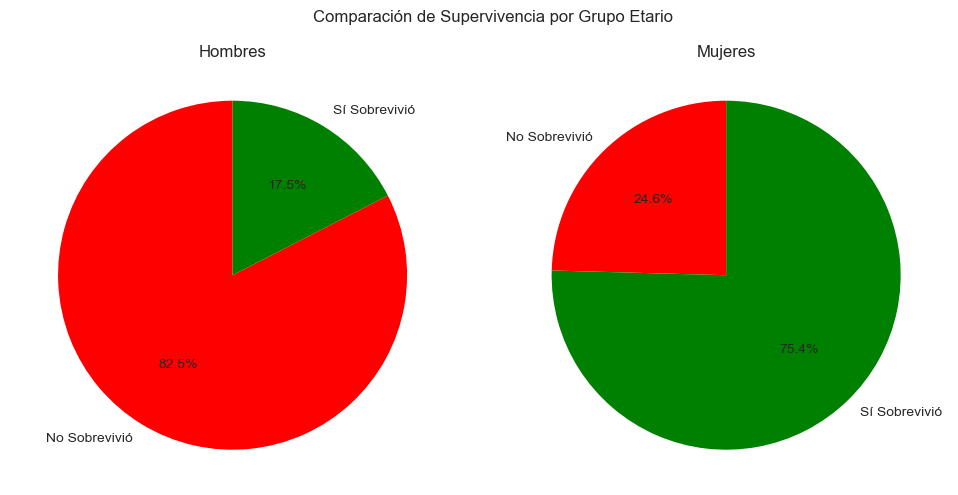

In [102]:
plots.pie(datas=[df_men, df_women], titles=['Hombres', 'Mujeres'], col='Percentage', n_pies=2)

>  De nuevo el porcentaje de mujeres que sobreviven es mayor que el de hombres, aunque en esta ocacion la diferencia no es tan brutal como si lo es en el conteo bruto

In [75]:
## exportar tabla
exportadores.exportar_tabla(df_grouped, "supervivencia_por_genero")

El archivo 'supervivencia_por_genero.csv' ya existe en d:\Uexternado\Segundo Semestre\Programacion 2\titanic-pandas-proyecto\notebooks\..\outputs\tablas. No se exportó.


## ¿Sobrevivieron mas niños que hombres adultos?

In [76]:
df_niños_adultos = tablas_cruzadas.cruzar_por_survived_etaria(df, gender="male", categoria="k_m")
df_niños_adultos[0]

,grupo etario,Survived,Count,Supervivencia_Etiqueta,total por grupo,Percent
0,hombre,0,646,No Sobrevivió,760,85.000000
1,hombre,1,114,Sí Sobrevivió,760,15.000000
2,niño,0,49,No Sobrevivió,82,59.756098
3,niño,1,33,Sí Sobrevivió,82,40.243902


In [77]:
plots.bar(data=df_niños_adultos[0], x='grupo etario', y='Count', title='Conteo de Supervivientes y No Sobrevivientes por Menoria-Mayoria edad', color='Supervivencia_Etiqueta')

Note que la cantidad bruta de hombres adultos que sobrevivio fue mucho mayor a los menores de edad que sobrevivieron.

In [78]:
exportadores.exportar_tabla(df_niños_adultos[0], "menores edad vs mayores edad")

El archivo 'menores edad vs mayores edad.csv' ya existe en d:\Uexternado\Segundo Semestre\Programacion 2\titanic-pandas-proyecto\notebooks\..\outputs\tablas. No se exportó.


In [79]:
df_hombre = df_niños_adultos[1]
df_nino = df_niños_adultos[2]
display(df_hombre)
display(df_nino)

,grupo etario,Survived,Count,Supervivencia_Etiqueta,total por grupo,Percent
0,hombre,0,646,No Sobrevivió,760,85.0
1,hombre,1,114,Sí Sobrevivió,760,15.0


,grupo etario,Survived,Count,Supervivencia_Etiqueta,total por grupo,Percent
2,niño,0,49,No Sobrevivió,82,59.756098
3,niño,1,33,Sí Sobrevivió,82,40.243902


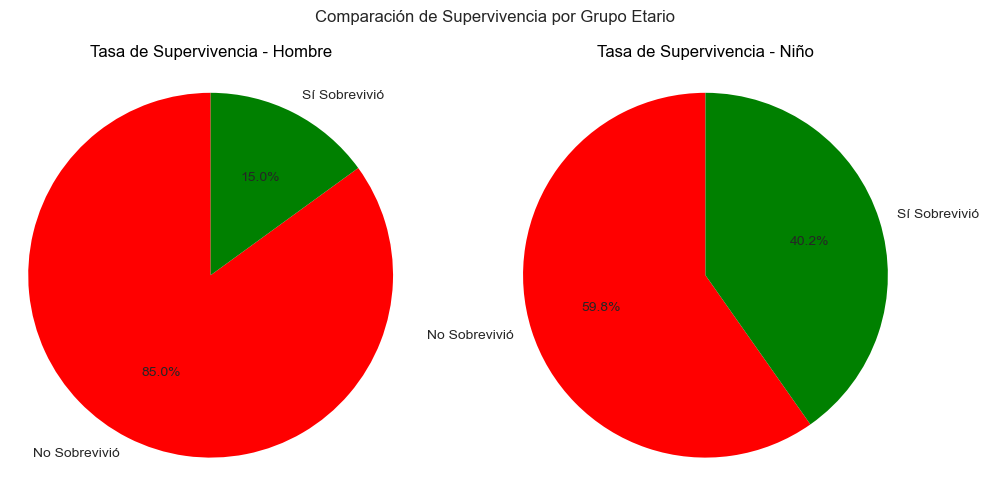

In [80]:
plots.pie(datas=[df_hombre, df_nino], n_pies=2, col='Percent', titles=['Tasa de Supervivencia - Hombre', 'Tasa de Supervivencia - Niño'])

> sin embargo porcentualmente es evidente que sobrevivieron muchos mas niños, el resultado contrario del grafico anterior se explica por la mayor cantidad de hombres adultos abordo.

In [81]:
exportadores.exportar_grafica(fig,'comparacion_supervivencia_etaria')

El archivo 'comparacion_supervivencia_etaria.png' ya existe en d:\Uexternado\Segundo Semestre\Programacion 2\titanic-pandas-proyecto\notebooks\..\outputs\graficos. No se exportó.


## ¿Pasajeros con edad mayor a 50 años o menor a 10 años sobrevevivieron mas que pasajeros en cualquier otro grupo etario?

In [82]:
df_cincuenta_diez_demas = tablas_cruzadas.cruzar_por_survived_etaria(df, categoria='c_d')
df_cincuenta_diez_demas[0]

,grupo etario,Survived,Count,Supervivencia_Etiqueta,total por grupo,Percent
0,mayor a 50 años,0,57,No Sobrevivió,93,61.290323
1,mayor a 50 años,1,36,Sí Sobrevivió,93,38.709677
2,menor a 10 años,0,28,No Sobrevivió,82,34.146341
3,menor a 10 años,1,54,Sí Sobrevivió,82,65.853659
4,ninguno de los grupos de interes,0,724,No Sobrevivió,1131,64.014147
5,ninguno de los grupos de interes,1,407,Sí Sobrevivió,1131,35.985853


In [83]:
exportadores.exportar_tabla(df_cincuenta_diez_demas[0], "cincuenta_diez_demas")

El archivo 'cincuenta_diez_demas.csv' ya existe en d:\Uexternado\Segundo Semestre\Programacion 2\titanic-pandas-proyecto\notebooks\..\outputs\tablas. No se exportó.


In [84]:
plots.bar(x='grupo etario', y='Count', title='SUpervivencia  segun grupo de edad', color='Supervivencia_Etiqueta', data=df_cincuenta_diez_demas[0])

en conteo bruto note que los grupos de interes contaron con la menor cantidad de superviventes, pero a su ved tambien son grupos muy minoritarios,  se procede a hacer el analisis porcentual

In [85]:
df_cincuenta = df_cincuenta_diez_demas[1]
df_diez = df_cincuenta_diez_demas[2]
df_otro = df_cincuenta_diez_demas[3]

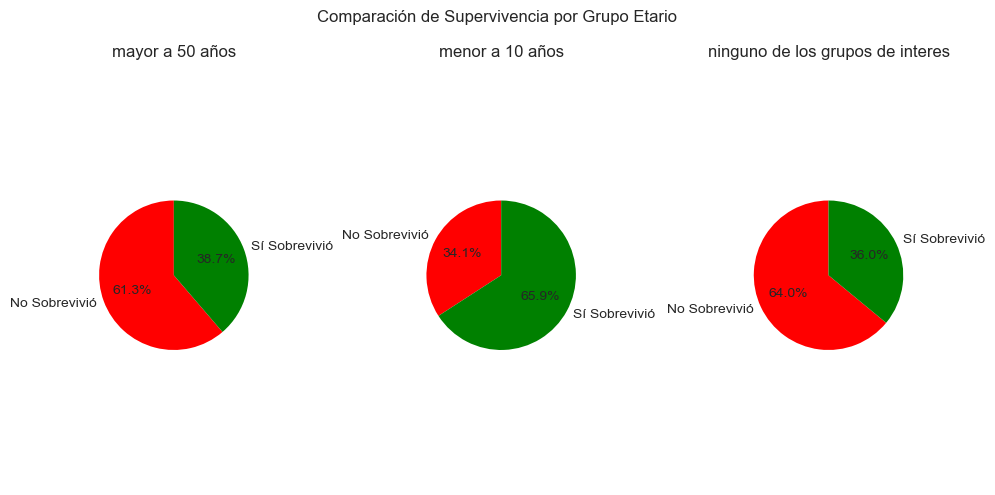

In [86]:
plots.pie(datas=[df_cincuenta, df_diez, df_otro ], n_pies=3, titles=['mayor a 50 años', 'menor a 10 años', 'ninguno de los grupos de interes'], col='Percent')

vea como con los porcentajes es evidente que los grupos etarios de interes tuvieron mayor ratio de supervivencia, con una clara ventaja para los menores de 10

In [87]:
exportadores.exportar_grafica(fig,'comparacion_supervivencia_etaria_50_10')

El archivo 'comparacion_supervivencia_etaria_50_10.png' ya existe en d:\Uexternado\Segundo Semestre\Programacion 2\titanic-pandas-proyecto\notebooks\..\outputs\graficos. No se exportó.


## ¿La mayor cantidad de pasajeros sobrevivientes partieron del puerto de Southampton o de los otros puertos?

In [88]:
df_southp =tablas_cruzadas.cruzar_ports_survived(df, port_interest='S')
df_southp

,Puerto de interes,Survived,Conteo,Total puerto,Percent,Supervivencia_Etiqueta
1,Otro,1,195,393,49.618321,Sí Sobrevivió
3,Southampton,1,302,913,33.077766,Sí Sobrevivió


In [89]:
exportadores.exportar_tabla(df_southp, "supervivencia por puerto")

El archivo 'supervivencia por puerto.csv' ya existe en d:\Uexternado\Segundo Semestre\Programacion 2\titanic-pandas-proyecto\notebooks\..\outputs\tablas. No se exportó.


In [90]:
plots.bar(data = df_southp, x='Puerto de interes', y='Conteo', color='Puerto de interes', title='Conteo de Supervivientes de Southampton')

el mayor numero de supervivientes viene de Southampton, tambien es importante precisar que la mayoria de los tripulantes provenen de ese puerto

In [91]:
df_Cherbourg = tablas_cruzadas.cruzar_ports_survived(data=df, only_surv=False, only_interest_port=True, port_interest='C')
df_Southampton = tablas_cruzadas.cruzar_ports_survived(data=df, only_surv=False, only_interest_port=True, port_interest='S')
df_Queenstown = tablas_cruzadas.cruzar_ports_survived(data=df, only_surv=False, only_interest_port=True, port_interest='Q')

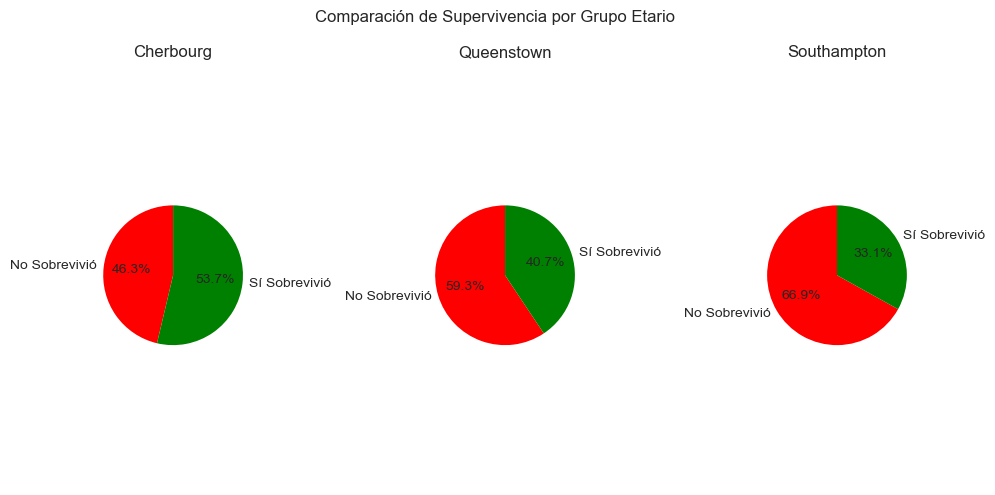

In [96]:
plots.pie(n_pies=3, datas=[df_Cherbourg, df_Queenstown, df_Southampton], titles=['Cherbourg', 'Queenstown', 'Southampton'], col='Percent')

Vea que los pasajeros provenientes de Southampton realmente tuvieron un ratio de supervivencia especialmente bajo.

In [93]:
exportadores.exportar_grafica(fig,  "supervivencia por puerto")

El archivo 'supervivencia por puerto.png' ya existe en d:\Uexternado\Segundo Semestre\Programacion 2\titanic-pandas-proyecto\notebooks\..\outputs\graficos. No se exportó.


##  ¿Pasajeros con tiquetes de primera clase sobrevivieron mas que pasajeros con otros tipos de tiquetes?

In [98]:
df_surv_class = tablas_cruzadas.cruzar_por_survived(df, 'Pclass')


df_primera = df_surv_class[df_surv_class['Pclass'] == 1]
df_segunda = df_surv_class[df_surv_class['Pclass'] == 2]
df_tercera = df_surv_class[df_surv_class['Pclass'] == 3]

df_surv_class

,Pclass,Survived,Count,Supervivencia_Etiqueta,Total_by_col,Percentage
0,1,0,121,No Sobrevivió,321,37.694704
1,1,1,200,Sí Sobrevivió,321,62.305296
2,2,0,158,No Sobrevivió,277,57.039711
3,2,1,119,Sí Sobrevivió,277,42.960289
4,3,0,530,No Sobrevivió,708,74.858757
5,3,1,178,Sí Sobrevivió,708,25.141243


In [95]:
plots.bar(x='Pclass',y='Count', title='survival segun clase', color='Supervivencia_Etiqueta', data=df_surv_class )

segun el conteo bruto los tripulantes de primera clase fueron los unicos que sumaros mas supervivientes que fallecidos.

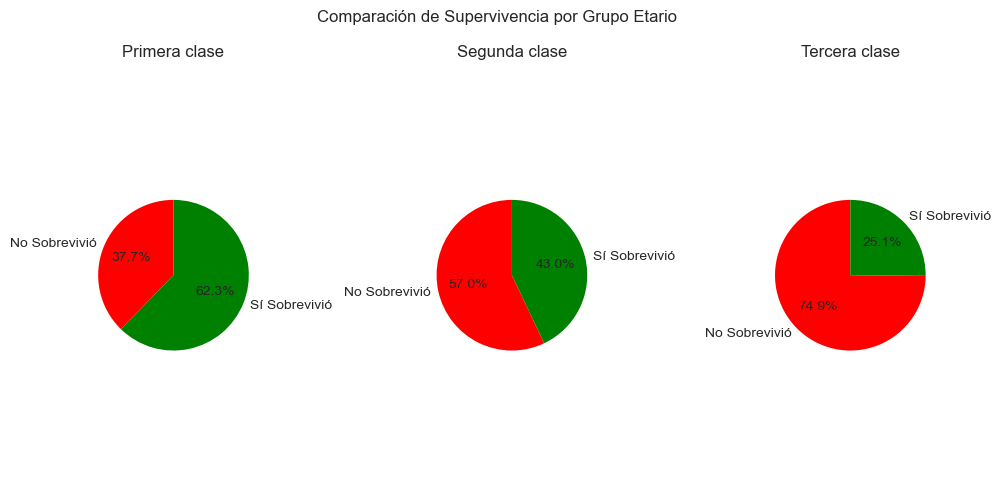

In [100]:
plots.pie(datas=[df_primera, df_segunda, df_tercera], titles=['Primera clase', 'Segunda clase', 'Tercera clase'], col='Percentage', n_pies=3)

Efectivamente la clase que tuvo las mejores probabilidades de sobrevivir,  mientras menor es la clase, menos chances habian de sobrevivir